# TimeGAN - Hands On Lab

### Introduction
A good generative model for time-series data should preserve temporal dynamics,
in the sense that new sequences respect the original relationships between variables across time. Existing methods that bring generative adversarial networks into the sequential setting do not adequately attend to the temporal correlations unique to time-series data. At the same time, supervised models for sequence prediction which allow finer control over network dynamics are inherently deterministic. 

TimeGAN has combined the flexibility of the unsupervised paradigm with the control afforded by supervised training to generate realistic time-series data. For this purpose, a new modules was added which is the autoencoder. This will part in accomplishing the mission of learning an embedding space jointly optimized with both supervised and adversarial objectives.

Released paper in December 2019 presented at NeurIPS by Yoon, Jarrett, and van der Schaar. Paper link https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks.pdf

### Learning Objectives
* Learn the timeGAN network design
* Training TimeGAN
* Explore Evaluation methods for timeGAN 

### Project Workflow

1. Selecting and preparing real and random time series inputs
2. Creating the key TimeGAN model components
3. Defining the various loss functions and training steps used during the three training
phases
4. Running the training loops and logging the results
5. Generating synthetic time series and evaluating the results

### Steps to run this notebook from Colaboratory

This colab will run much faster on GPU. To use a Google Cloud
GPU:

1. Go to `Runtime > Change runtime type`.
1. Click `Hardware accelerator`.
1. Select `GPU` and click `Save`.
1. Click `Connect` in the upper right corner and select `Connect to hosted runtime`.






### Mount Drive

In [ ]:
!pip install tqdm
#!pip install pandas_datareader==0.7.0
#!pip install pandas-datareader --upgrade
#!pip install tables
!pip install quandl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### IMPORTS

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import random
from pandas_datareader import data
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
import quandl

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

### CONFIGS

In [ ]:
cols=['Ia', 'Ib', 'Ic', 'Idc', 'RPM', 'Torque', 'Ia_RMS', 'Ib_RMS', 'Ic_RMS']
portent_p=pd.read_excel('/content/drive/MyDrive/IPM 모터 고장 실험(상개방, interturn short)데이터_2000RPM_1ms.xlsx',header=1,sheet_name=1,usecols=cols)
portent_i=pd.read_excel('/content/drive/MyDrive/IPM 모터 고장 실험(상개방, interturn short)데이터_2000RPM_1ms.xlsx',header=1,sheet_name=2,usecols=cols)
portent_p=portent_p.iloc[:160,:]
portent_i=portent_i.iloc[:160,:]
print(portent_p.shape,portent_i.shape)

(160, 9) (160, 9)


In [ ]:
portent_p = tf.data.Dataset.from_tensor_slices(portent_p)
portent_p = portent_p.window(24,shift=1,drop_remainder=True)
list_p = []
for d in portent_p:
    i2 = list(d.as_numpy_iterator())
    list_p.append(i2)

portent_p = np.array(list_p)
print(portent_p.shape)

portent_i = tf.data.Dataset.from_tensor_slices(portent_i)
portent_i = portent_i.window(24,shift=1,drop_remainder=True)
list_i = []
for d in portent_i:
    i2 = list(d.as_numpy_iterator())
    list_i.append(i2)

portent_i = np.array(list_i)
print(portent_i.shape)

(137, 24, 9)
(137, 24, 9)


In [ ]:
from sklearn.model_selection import train_test_split
Xp_train,Xp_test=train_test_split(portent_p,random_state=42,shuffle=True,test_size=0.2)
Xi_train,Xi_test=train_test_split(portent_i,random_state=42,shuffle=True,test_size=0.2)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
Xp=scaler.fit_transform(Xp_train.reshape(-1,9)).reshape(-1,24,9).astype(np.float32)
Xi=scaler.fit_transform(Xi_train.reshape(-1,9)).reshape(-1,24,9).astype(np.float32)

In [ ]:
# Experiments path
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()

experiment = 1
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)
hdf_store = results_path / 'TimeSeriesGAN.h5'



# Model Hyperparameters
seq_len = 24 #window 크기
n_seq = 9 #변수개수
batch_size = 8
hidden_dim = 24
num_layers = 3
train_steps = 10000
gamma = 1

# Data
'''api_key = "Your API KEY"
start_date = '1990-01-01'
end_date = '2019-02-01'

# A fixed random seed is a common "trick" used in ML that allows us to recreate
# the same data when there is a random element involved.'''
seed = random.seed(30)

In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
n_windows=len(Xi)
real_series = (tf.data.Dataset.from_tensor_slices(Xi).shuffle(buffer_size=n_windows).batch(batch_size))
real_series_iter = iter(real_series.repeat())

In [ ]:
# Set up Random Series Generator
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

In [ ]:
random_series = iter(tf.data.Dataset.from_generator(make_random_data, output_types=tf.float32).batch(batch_size).repeat())

In [ ]:
# Fix model inputs
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

### Modeling
![Discriminator.png](https://drive.google.com/uc?export=view&id=1NeG9CjB7hfAg7TlTlWY_kbGSLxAihHXd)

In [ ]:
### RNN block generator
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

#### AutoEncoder

In [ ]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

#### Generator & Discriminator

In [ ]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

### Training Process

Training takes place in three phases:
1. Training the autoencoder on real time series to optimize reconstruction
2. Optimizing the supervised loss using real time series to capture the temporal
dynamics of the historical data
3. Jointly training the four components while minimizing all three loss functions

In [ ]:
## Losses
mse = MeanSquaredError()
bce = BinaryCrossentropy()

In [ ]:
autoencoder_optimizer = Adam()
supervisor_optimizer = Adam()
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

#### Phase 1: Autoencoder Training

In [ ]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [ ]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 9)]           0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            10320     
                                                                 
 Recovery (Sequential)       (None, 24, 9)             11025     
                                                                 
Total params: 21,345
Trainable params: 21,345
Non-trainable params: 0
_________________________________________________________________


In [ ]:
@tf.function ##
def train_autoencoder_init(x):
    with tf.GradientTape() as tape: ##자동미분기능 : 동적으로 gradient값 확인 가능
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list) ##gradient계산
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list)) #오차역전파
    return tf.sqrt(embedding_loss_t0)

In [ ]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

In [ ]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|██████████| 10000/10000 [02:10<00:00, 76.74it/s]


### Phase 2: Supervised training

In [ ]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :1, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

In [ ]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 10000/10000 [01:17<00:00, 128.43it/s]


### Phase 3: Joint Training
#### Generator
##### Adversarial Architecture - Supervised

In [ ]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [ ]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 9)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            10320     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 28,945
Trainable params: 28,945
Non-trainable params: 0
_________________________________________________________________


##### Adversarial Architecture in Latent Space

In [ ]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [ ]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 9)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            10320     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 21,145
Trainable params: 21,145
Non-trainable params: 0
_________________________________________________________________


#### Mean & Variance Loss

In [ ]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [ ]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 9)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            10320     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Recovery (Sequential)       (None, 24, 9)             11025     
                                                                 
Total params: 29,145
Trainable params: 29,145
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

### Discriminator

In [ ]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [ ]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 9)]           0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            10320     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 21,145
Trainable params: 21,145
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [ ]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, :1, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

In [ ]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, :1, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [ ]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [ ]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

In [ ]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

     0 | d_loss: 2.2908 | g_loss_u: 0.5509 | g_loss_s: 0.0719 | g_loss_v: 1.5280 | e_loss_t0: 0.8293
 1,000 | d_loss: 0.7521 | g_loss_u: 4.5742 | g_loss_s: 0.0200 | g_loss_v: 0.7412 | e_loss_t0: 0.6187
 2,000 | d_loss: 0.7129 | g_loss_u: 3.4393 | g_loss_s: 0.0143 | g_loss_v: 0.9259 | e_loss_t0: 0.7450
 3,000 | d_loss: 0.4913 | g_loss_u: 3.0039 | g_loss_s: 0.0114 | g_loss_v: 0.9095 | e_loss_t0: 0.7623
 4,000 | d_loss: 0.8912 | g_loss_u: 5.3497 | g_loss_s: 0.0093 | g_loss_v: 0.9278 | e_loss_t0: 0.7586
 5,000 | d_loss: 0.2500 | g_loss_u: 5.2526 | g_loss_s: 0.0071 | g_loss_v: 0.8662 | e_loss_t0: 0.7485
 6,000 | d_loss: 0.6411 | g_loss_u: 4.1594 | g_loss_s: 0.0063 | g_loss_v: 0.9342 | e_loss_t0: 0.7992
 7,000 | d_loss: 0.7626 | g_loss_u: 4.0829 | g_loss_s: 0.0061 | g_loss_v: 0.8516 | e_loss_t0: 0.7389
 8,000 | d_loss: 0.4697 | g_loss_u: 3.8755 | g_loss_s: 0.0050 | g_loss_v: 0.8386 | e_loss_t0: 0.7155
 9,000 | d_loss: 1.2574 | g_loss_u: 6.1405 | g_loss_s: 0.0050 | g_loss_v: 0.8348 | e_loss_t

#### Generate Synthetic Data

In [ ]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [ ]:
len(generated_data)

13

In [ ]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(104, 24, 9)

In [ ]:
np.save(log_dir / 'error_i_portent1.npy', generated_data)

### Rescale

In [ ]:
generated_data = (scaler.inverse_transform(generated_data.reshape(-1, n_seq)).reshape(-1, seq_len, n_seq))
generated_data.shape

(104, 24, 9)

In [ ]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq)))

In [ ]:
np.save(log_dir / 'portent_p_generated_data_inverse1.npy', generated_data)

In [ ]:
np.save('/content/drive/MyDrive/time_gan/experiment_00/eerror_i_portent_generated_data_inverse1.npy', generated_data)

In [ ]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

generated_data = np.array(np.vstack(generated_data))
generated_data = (scaler.inverse_transform(generated_data.reshape(-1, n_seq)).reshape(-1, seq_len, n_seq))

np.save('/content/drive/MyDrive/time_gan/experiment_00/eerror_i_portent_generated_data_inverse2.npy', generated_data)

generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

generated_data = np.array(np.vstack(generated_data))
generated_data = (scaler.inverse_transform(generated_data.reshape(-1, n_seq)).reshape(-1, seq_len, n_seq))

np.save('/content/drive/MyDrive/time_gan/experiment_00/eerror_i_portent_generated_data_inverse3.npy', generated_data)

generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

generated_data = np.array(np.vstack(generated_data))
generated_data = (scaler.inverse_transform(generated_data.reshape(-1, n_seq)).reshape(-1, seq_len, n_seq))

np.save('/content/drive/MyDrive/time_gan/experiment_00/eerror_i_portent_generated_data_inverse4.npy', generated_data)

In [ ]:
generated_data.shape

(104, 24, 9)

In [ ]:
synthetic.shape

NameError: ignored

#### Plot sample Series

ValueError: ignored

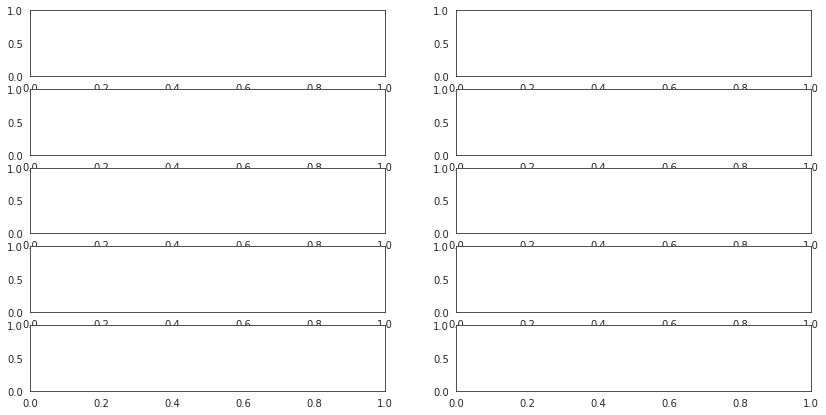

In [ ]:
#tickers=['Ia','Ib','Ic','Idc','RPM','Torque','Ia_RMS','Ib_RMS','IC_RMS']
tickers=cols
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 10))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(Xp) - seq_len)
real = Xp[idx: idx + seq_len]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real[:, j],
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()

### Evaluation Pipeline

In [ ]:
def get_real_data(dataset):

    # Preprocess the dataset:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(dataset)

    data = []
    for i in range(len(dataset) - seq_len):
        data.append(scaled_data[i:i + seq_len])
    return data


real_data = get_real_data(Xp)

In [ ]:
real_data = real_data[:generated_data.shape[0]]

In [ ]:
sample_size = 50
idx = np.random.permutation(len(real_data))[:sample_size]

In [ ]:
# Data preprocessing
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(generated_data)[idx]

In [ ]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
            .assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                 .assign(Data='Synthetic'))
pca_result = pca_real.append(pca_synthetic).rename(
    columns={0: '1st Component', 1: '2nd Component'})

In [ ]:
tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

In [ ]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*6:, 'Data'] = 'Synthetic'

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_result,
                hue='Data', 
                style='Data', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);

#### Refrences:

Book: Machine Learning for algorithmic trading

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score

#%% Post-hoc RNN Classifier 

def discriminative_score_metrics (dataX, dataX_hat):
  
    # Initialization on the Graph
    tf.reset_default_graph()

    # Basic Parameters
    No = len(dataX)
    data_dim = len(dataX[0][0,:])
    
    # Compute Maximum seq length and each seq length
    dataT = list()
    Max_Seq_Len = 0
    for i in range(No):
        Max_Seq_Len = max(Max_Seq_Len, len(dataX[i][:,0]))
        dataT.append(len(dataX[i][:,0]))
     
    # Network Parameters
    hidden_dim = max(int(data_dim/2),1)
    iterations = 2000
    batch_size = 128
    
    #%% input place holders
    # Features
    X = tf.placeholder(tf.float32, [None, Max_Seq_Len, data_dim], name = "myinput_x")
    X_hat = tf.placeholder(tf.float32, [None, Max_Seq_Len, data_dim], name = "myinput_x_hat")
    
    # Times
    T = tf.placeholder(tf.int32, [None], name = "myinput_t")
    T_hat = tf.placeholder(tf.int32, [None], name = "myinput_t_hat")
    
    #%% builde a RNN classification network 
    
    def discriminator (X, T):
      
        with tf.variable_scope("discriminator", reuse = tf.AUTO_REUSE) as vs:
            
            d_cell = tf.nn.rnn_cell.GRUCell(num_units=hidden_dim, activation=tf.nn.tanh, name = 'cd_cell')
                    
            d_outputs, d_last_states = tf.nn.dynamic_rnn(d_cell, X, dtype=tf.float32, sequence_length = T)
                
            # Logits
            Y_hat = tf.contrib.layers.fully_connected(d_last_states, 1, activation_fn=None) 
            
            # Sigmoid output
            Y_hat_Final = tf.nn.sigmoid(Y_hat)
            
            # Variables
            d_vars = [v for v in tf.all_variables() if v.name.startswith(vs.name)]
    
        return Y_hat, Y_hat_Final, d_vars
    
    #%% Train / Test Division
    def train_test_divide (dataX, dataX_hat, dataT):
      
        # Divide train/test index
        No = len(dataX)
        idx = np.random.permutation(No)
        train_idx = idx[:int(No*0.8)]
        test_idx = idx[int(No*0.8):]
        
        # Train and Test X
        trainX = [dataX[i] for i in train_idx]
        trainX_hat = [dataX_hat[i] for i in train_idx]
        
        testX = [dataX[i] for i in test_idx]
        testX_hat = [dataX_hat[i] for i in test_idx]
        
        # Train and Test T
        trainT = [dataT[i] for i in train_idx]
        testT = [dataT[i] for i in test_idx]
      
        return trainX, trainX_hat, testX, testX_hat, trainT, testT
    
    #%% Functions
    # Variables
    Y_real, Y_pred_real, d_vars = discriminator(X, T)
    Y_fake, Y_pred_fake, _ = discriminator(X_hat, T_hat)
        
    # Loss for the discriminator
    D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Y_real, labels = tf.ones_like(Y_real)))
    D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Y_fake, labels = tf.zeros_like(Y_fake)))
    D_loss = D_loss_real + D_loss_fake
    
    # optimizer
    D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list = d_vars)
        
    #%% Sessions    

    # Start session and initialize
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    # Train / Test Division
    trainX, trainX_hat, testX, testX_hat, trainT, testT = train_test_divide (dataX, dataX_hat, dataT)
    
    # Training step
    for itt in range(iterations):
          
        # Batch setting
        idx = np.random.permutation(len(trainX))
        train_idx = idx[:batch_size]     
            
        X_mb = list(trainX[i] for i in train_idx)
        T_mb = list(trainT[i] for i in train_idx)
        
        # Batch setting
        idx = np.random.permutation(len(trainX_hat))
        train_idx = idx[:batch_size]     
            
        X_hat_mb = list(trainX_hat[i] for i in train_idx)
        T_hat_mb = list(trainT[i] for i in train_idx)
          
        # Train discriminator
        _, step_d_loss = sess.run([D_solver, D_loss], feed_dict={X: X_mb, T: T_mb, X_hat: X_hat_mb, T_hat: T_hat_mb})            
        
        #%% Checkpoints
#        if itt % 500 == 0:
#            print("[step: {}] loss - d loss: {}".format(itt, np.round(step_d_loss,4)))
    
    #%% Final Outputs (ontTesting set)
    
    Y_pred_real_curr, Y_pred_fake_curr = sess.run([Y_pred_real, Y_pred_fake], feed_dict={X: testX, T: testT, X_hat: testX_hat, T_hat: testT})
    
    Y_pred_final = np.squeeze(np.concatenate((Y_pred_real_curr, Y_pred_fake_curr), axis = 0))
    Y_label_final = np.concatenate((np.ones([len(Y_pred_real_curr),]), np.zeros([len(Y_pred_real_curr),])), axis = 0)
    
    #%% Accuracy
    Acc = accuracy_score(Y_label_final, Y_pred_final>0.5)
    
    Disc_Score = np.abs(0.5-Acc)
    
    return Disc_Score

In [ ]:
from sklearn.metrics import mean_absolute_error

#%% Post-hoc RNN one-step ahead predictor

def predictive_score_metrics (dataX, dataX_hat):
  
    # Initialization on the Graph
    tf.reset_default_graph()

    # Basic Parameters
    No = len(dataX)
    data_dim = len(dataX[0][0,:])
    
    # Maximum seq length and each seq length
    dataT = list()
    Max_Seq_Len = 0
    for i in range(No):
        Max_Seq_Len = max(Max_Seq_Len, len(dataX[i][:,0]))
        dataT.append(len(dataX[i][:,0]))
     
    # Network Parameters
    hidden_dim = max(int(data_dim/2),1)
    iterations = 5000
    batch_size = 128
    
    #%% input place holders
    
    X = tf.placeholder(tf.float32, [None, Max_Seq_Len-1, data_dim-1], name = "myinput_x")
    T = tf.placeholder(tf.int32, [None], name = "myinput_t")    
    Y = tf.placeholder(tf.float32, [None, Max_Seq_Len-1, 1], name = "myinput_y")
    
    #%% builde a RNN discriminator network 
    
    def predictor (X, T):
      
        with tf.variable_scope("predictor", reuse = tf.AUTO_REUSE) as vs:
            
            d_cell = tf.nn.rnn_cell.GRUCell(num_units=hidden_dim, activation=tf.nn.tanh, name = 'd_cell')
                    
            d_outputs, d_last_states = tf.nn.dynamic_rnn(d_cell, X, dtype=tf.float32, sequence_length = T)
                
            Y_hat = tf.contrib.layers.fully_connected(d_outputs, 1, activation_fn=None) 
            
            Y_hat_Final = tf.nn.sigmoid(Y_hat)
            
            d_vars = [v for v in tf.all_variables() if v.name.startswith(vs.name)]
    
        return Y_hat_Final, d_vars
    
    #%% Functions
    # Variables
    Y_pred, d_vars = predictor(X, T)
        
    # Loss for the predictor
    D_loss = tf.losses.absolute_difference(Y, Y_pred)
    
    # optimizer
    D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list = d_vars)
        
    #%% Sessions    

    # Session start
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    # Training using Synthetic dataset
    for itt in range(iterations):
          
        # Batch setting
        idx = np.random.permutation(len(dataX_hat))
        train_idx = idx[:batch_size]     
            
        X_mb = list(dataX_hat[i][:-1,:(data_dim-1)] for i in train_idx)
        T_mb = list(dataT[i]-1 for i in train_idx)
        Y_mb = list(np.reshape(dataX_hat[i][1:,(data_dim-1)],[len(dataX_hat[i][1:,(data_dim-1)]),1]) for i in train_idx)        
          
        # Train discriminator
        _, step_d_loss = sess.run([D_solver, D_loss], feed_dict={X: X_mb, T: T_mb, Y: Y_mb})            
        
        #%% Checkpoints
#        if itt % 500 == 0:
#            print("[step: {}] loss - d loss: {}".format(itt, np.sqrt(np.round(step_d_loss,4))))
    
    #%% Use Original Dataset to test
    
    # Make Batch with Original Data
    idx = np.random.permutation(len(dataX_hat))
    train_idx = idx[:No]     
    
    X_mb = list(dataX[i][:-1,:(data_dim-1)] for i in train_idx)
    T_mb = list(dataT[i]-1 for i in train_idx)
    Y_mb = list(np.reshape(dataX[i][1:,(data_dim-1)], [len(dataX[i][1:,(data_dim-1)]),1]) for i in train_idx)
    
    # Predict Fugure
    pred_Y_curr = sess.run(Y_pred, feed_dict={X: X_mb, T: T_mb})
    
    # Compute MAE
    MAE_Temp = 0
    for i in range(No):
        MAE_Temp = MAE_Temp + mean_absolute_error(Y_mb[i], pred_Y_curr[i,:,:])
    
    MAE = MAE_Temp / No
    
    return MAE